In [2]:
import yaml
import re
import enum
from pprint import pprint, pformat
from tabulate import tabulate
import itertools
import random
import math
import time

from dataclasses import dataclass
from typing import List, Tuple, Set
from copy import copy, deepcopy

# def listify_spec(spec):
#   listable = set({'affects', 'covered-by', 'mapto', 'actions'})
#   recursable = set({'structures'})
#   top-level = set({'structures', 'object-types', 'structure-types', 'representation-types', 'behavior-types'})

#   for key, content in spec.items():

def parse_spec(file_path):
  with open(file_path, 'r') as file_handle:
    spec = yaml.safe_load(file_handle)
  return spec

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
ex_spec = parse_spec('video-editor.yaml')

## Comparing Objects

In [5]:
# TODO: refactor to use listable instead of this function
def process_listable(target, func):
  if target is None:
    return

  if type(target) == list:
    for target_item in target:
      func(target_item)
  else:
    func(target)

# Return a list even if it's a single thing, so you can always loop through it
def listable(content):
  if type(content) is str:
    return [content]
  elif type(content) is list:
    return content
  elif content is None:
    return []
  else:
    print('Listable item is of type:', type(content))
    assert(False)

def strip_type(obj):
  return re.sub(r'\((\w|-)*\) ', '', obj)


In [6]:
class ObjectRegistry(object):
  # obj mapto obj registry
  # {obj name: set(obj names)}
  registry: dict[str, Set[str]] = {}
  
  # # registry for structures between structures, repr, etc.
  # # {obj name: set((entity-name, connection-type), etc...) }
  # connections: dict[str, Set[Tuple[str, str]]] = {}

  def __init__(self, spec=None):
    self.registry = {}
    if spec is not None:
      self.register_spec_objects(spec)

  def __str__(self):
    return pformat(self.registry)

  def register_object(self, obj):
    # -> means mapto
    # . means subset
    # / means component  # TODO: actually do this!!
    assert(type(obj) is str)
    obj = strip_type(obj)

    arrow_array = obj.split('->')
    for arrow_idx, arrow_term in enumerate(arrow_array):
      
      dot_array = arrow_term.split('.')
      for dot_idx, dot_term in enumerate(dot_array):
        subject = '.'.join(dot_array[:dot_idx + 1]) # join up to idx
        if not self.registry.get(subject):
          self.registry[subject] = set()
        
        if dot_idx > 0:
          # every sequence maps to the previous element eg. a.b.c => {a.b.c: {a.b}, a.b: {a}}
          previous = '.'.join(dot_array[:dot_idx])
          self.registry[subject].add(previous)
      
      if arrow_idx > 0:
        # a pair of arrows lhs->rhs => {lhs: {rhs}}
        lhs = self.registry[arrow_array[arrow_idx - 1]]
        rhs = arrow_array[arrow_idx]
        lhs.add(rhs)

  def register_struct_objects(self, struct, process_func):
    if struct.get('type') == 'group':
      # Groups also behave as objects, so register them
      name = struct.get('name')
      if name is None:
        print('Warning! No name provided for group. Using `NO NAME PROVIDED` instead. TODO: generate ID.')
        name = 'NO NAME PROVIDED'

      if self.registry.get(name) is None:
        self.registry[name] = set()
      
      # TODO: do groups map to their elements? Really, does the transitive property apply? My hunch is no, but need to think more

    process_listable(struct.get('affects'), process_func)
    process_listable(struct.get('covered-by'), process_func)
    # TODO: relate all of the objects affected/covered by a structure. 

    for derivative in struct.get('structures', []):
      self.register_struct_objects(derivative, process_func=process_func)

  def register_repr_objects(self, repr, process_func):
    repr_type = repr.get('type', '')
    # print(repr_type)
    for repr_item in repr.get('objects', []):
      assert(type(repr_item) is dict)
      assert(len(list(repr_item.keys())) == 1)
      repr_obj = list(repr_item.keys())[0]


      if type(repr_item[repr_obj]) is str:
        # turn str into list to iterate through it properly
        repr_item[repr_obj] = [repr_item[repr_obj]]

      # assert(len(repr_item.values()) == 1)
      # repr_obj, target_objs = list(repr_item.items())[0]
      for target_obj in repr_item[repr_obj]:
        process_func(target_obj)
        # Map every item to the associated representational object
        # eg. {message: {textbox}, author: {textbox}}
        if self.registry.get(target_obj) is None:
          self.registry[target_obj] = set()
        self.registry[target_obj].add(repr_obj)
        # objects[target].add(repr_type + '/' + repr_obj)  # when we prefix the core stuff
        # note: this is a bit backwards compared to the syntax!


  def register_spec_objects(self, spec): # {object: [mapto-targets]}
    def register_object_here(target):
      self.register_object(target)
    
    process_listable(spec.get('objects'), register_object_here)
    # TODO: deal with `objects` block

    for struct in spec.get('structures', []):
      self.register_struct_objects(struct, register_object_here)
      
    for repr in spec.get('representations', []):
      self.register_repr_objects(repr, register_object_here)


In [7]:
# Test in Object Registry
print('testing: a')
test = ObjectRegistry()
print('expected:')
pprint({'a': set()})
print('got:')
test.register_object('a')
print(test)

print()

print('testing: a.b.c')
print('expected:')
pprint({'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}})
print('got:')
test = ObjectRegistry()
test.register_object('a.b.c')
print(test)

print()

print('testing: a->b->c')
print('expected:')
pprint({'a': {'b'}, 'b': {'c'}, 'c': set()})

print('got:')
test = ObjectRegistry()
test.register_object('a->b->c')
print(test)

print()

print('testing: a.b->x->z.w')
print('expected:')
print({'a': set(), 'a.b': {'x', 'a'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}})

print('got:')
test = ObjectRegistry()
test.register_object('a.b->x->z.w')
print(test)

testing: a
expected:
{'a': set()}
got:
{'a': set()}

testing: a.b.c
expected:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}
got:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}

testing: a->b->c
expected:
{'a': {'b'}, 'b': {'c'}, 'c': set()}
got:
{'a': {'b'}, 'b': {'c'}, 'c': set()}

testing: a.b->x->z.w
expected:
{'a': set(), 'a.b': {'a', 'x'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}
got:
{'a': set(), 'a.b': {'a', 'x'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}


In [8]:
print('testing: days.selected->events')
print('expected:')
pprint({'days.selected': {'events', 'days'}, 'days': set(), 'events': set()})

print('got:')
test = ObjectRegistry()

test.register_object('days.selected->events')
print(test)

testing: days.selected->events
expected:
{'days': set(), 'days.selected': {'days', 'events'}, 'events': set()}
got:
{'days': set(), 'days.selected': {'days', 'events'}, 'events': set()}


In [9]:
ex_obj_registry = ObjectRegistry()
ex_obj_registry.register_spec_objects(ex_spec)
print(ex_obj_registry)

{'playhead': {'vlines', 'videos.in-editor/images'},
 'playhead->videos.in-editor/images': {'rects'},
 'timestamps': {'vlines'},
 'tracks': {'regions'},
 'videos': set(),
 'videos.in-editor': {'videos', 'rects'},
 'videos.in-editor/images': {'videos'},
 'videos/first-frame': {'regions'}}


In [10]:
core_spec = parse_spec('core.yaml')
core_objs = ObjectRegistry()

# TODO: probably need to consider prefixing gui on these
for repr_type in core_spec.get('representation-types', []):
  # print(repr_type['name'])
  core_objs.register_spec_objects(repr_type)

# register_spec_objects(core_spec, core_objs)
print(core_objs)

{'hlines': {'lines'},
 'icons': {'regions'},
 'lines': {'regions'},
 'points': set(),
 'rects': {'regions'},
 'regions': set(),
 'vlines': {'lines'}}


In [11]:
# NOTE: This is general! Assuming your relations/registry is shaped properly
# TODO: count depth
def get_node_join(left, right, relations, visited=set(), depth=0) -> str | None:
  assert(type(left) is str)
  assert(type(right) is str)
  
  if relations.get(left) is None or relations.get(right) is None:
    return None

  # Trace print
  # print(f"{left:<8} {right:<}")

  if left in visited or right in visited:
    # To avoid cycles, abort if we've already visited a node
    # NOTE: Not like 100% sure this is clean
    print("WARNING! Cycle detected in the relations.")
    return None

  if left == right:
    return left
  
  for next_left in relations[left]:
    left_res = get_node_join(next_left, right, relations, visited=visited)
    if left_res is None:
      # When you reach the leaf of a spanning tree, pop back up to recurse
      for next_right in relations[right]:
        return get_node_join(left, next_right, relations, visited=visited)
    else:
      return left_res

  if len(relations[right]) == 0 and len(relations[left]) == 0:
    return None

print()
print('vlines, hlines => ' + str(get_node_join('vlines', 'hlines', core_objs.registry)))
print('rects, hlines => ' + str(get_node_join('rects', 'hlines', core_objs.registry)))
print('points, hlines => ' + str(get_node_join('points', 'hlines', core_objs.registry)))


vlines, hlines => lines
rects, hlines => regions
points, hlines => None


## Comparing Structures
- need to show that two structures are "the same" based on their types
- do structures map to other structures

In [12]:
class StructRegistry(object):
  # Keep track of the type of each structure
  # TODO: I guess you only ever have the one type huh? keeping it a set for now
  # so that I can use get_node_join() without changing it.
  typeRegistry: dict[str, Set[str]] = {}

  # Keep track of which structure maps to which
  mapRegistry: dict[str, Set[str]] = {}

  def __init__(self, spec=None, core_spec=None):
    self.typeRegistry = {}
    self.mapRegistry = {}
    if spec is not None:
      self.register_spec(spec)
    
    if core_spec is None:
      # HACK: this probably shouldn't be hard-coded
      self.core_spec = parse_spec('core.yaml')
  
  def _prefix(parents: List[str]):
    return '/'.join(parents) + '/'

  def register_struct(self, struct, parents=None):
    name = struct.get('name')
    assert(name is not None)

    # TODO: do prefixes for structure components
    prefix = '' if parents is None else self._prefix(parents)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    if struct_type := struct.get('type'):
      self.typeRegistry[name].add(struct_type) 

    # Register map
    if self.mapRegistry.get(name) is None:
      self.mapRegistry[name] = set()
    
    if struct_maps := struct.get('mapto'):
      def process_struct_map(target):
        self.mapRegistry[name].add(target)
      
      process_listable(struct_maps, process_struct_map)
    
    # Registrer connections for objects
    # TODO
  
  def register_spec(self, spec, parents=None):
    for struct_type in core_spec.get('structure-types', []):
      self.register_struct_type(struct_type)

    for struct in spec.get('structures', []):
      self.register_struct(struct, parents)
  
  def register_struct_type(self, struct_type):
    # TODO: not 100% sure about how the semantics are being used (ie. type mapto is like a type for structure)
    name = struct_type.get('name')
    assert(name is not None)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    # HACK: for the sake of comparing the type of structures from two different specs, it's easiest to think of
    # component-mapto as a type relation 
    if target := struct_type.get('mapto'):
      self.typeRegistry[name].add(target)
      
      

## Construct Graph for Pattern Matching

How does this thing even work?  

Nodes are structures.  
A directed edge between nodes if S1 mapsto S2.
An undirected edge between nodes if they refer to 


In [13]:
__next_id = 0
def new_id():
  global __next_id
  current = __next_id
  __next_id += 1
  return current

def reset_id_gen():
  global __next_id
  print("WARNING: Resetting ID Gen, any previously generated ids are no longer meaningful.")
  __next_id = 0

In [14]:
class NodeKind(enum.Enum):
  Structure = enum.auto()

class EdgeKind(enum.Enum):
  # Directed
  StructMap = enum.auto()

  # Undirected
  ObjRef = enum.auto()


@dataclass
class Node:
  id: int
  kind: NodeKind
  def __str__(self):
    return f'{self.kind}: {self.id}'

@dataclass
class Edge:
  id: int
  kind: EdgeKind
  label: str
  source: int
  target: int

  def __str__(self):
    return f'{self.kind}: ({self.source}-{self.target})'

@dataclass
class Graph:
  nodes: List[Node]
  edges: List[Edge]

  def __str__(self):
    res = 'Nodes:\n'
    res += ', '.join([str(n) for n in self.nodes])
    res += '\n'
    res += 'Edges: \n'
    res += '\n'.join([str(e) for e in self.edges])
    return res

In [15]:
def register_id(name: str, registry: dict[str, int]) -> int:
  if existing_id := registry.get(name) is None:
    return existing_id
  
  new_id = new_id()
  registry[name] = new_id
  return new_id
  

def make_graph(spec_file: str) -> Graph:
  graph = Graph([],[])
  spec = parse_spec(spec_file)  
  
  obj_reg = ObjectRegistry()
  obj_reg.register_spec_objects(spec)

  struct_reg = StructRegistry()
  struct_reg.register_spec(spec)
  
  ids: dict[str, int] = {} # { spec_name: id }
  for struct in spec.get('structures', []):
    struct_name = struct.get('name')
    assert(struct_name is not None)

    struct_node = Node(register_id(struct_name), NodeKind.Structure)
    graph.nodes.append(struct_node)


## Error Tolerant Graph Matching

In [16]:
# Returns
# [
#   [first pairing],
#   [second pairing],
#   ...
# ]
def list_pairings(s1: Set, s2: Set):
  assert(len(s1) <= len(s2))
  l1 = list(s1)
  mappings = []

  for subset_choice in itertools.combinations(s2, len(s1)):
    # Pick a subset that you want to look at
    for permutation in itertools.permutations(subset_choice):
      # try all permutations of s2 against (static) s1
      mappings.append(list(zip(l1, permutation)))
  
  return mappings

# def count_list_pairings(s1: Set, s2: Set):
#   assert(len(s1) <= len(s2))
#   return math.comb(len(s2), len(s1)) * math.perm(len(s1))

In [17]:
def subset_pairings(s1: Set, s2: Set, size):
  l1 = list(s1)
  l2 = list(s2)

  assert(size <= len(l1) <= len(l2))

  res = []
  for subset1 in itertools.combinations(s1, size):
    for subset2 in itertools.combinations(s2, size):
      # Pick out a subset for s1 and s2, and list their pairings
      # print(len(list_pairings(subset1, subset2)))
      res += list_pairings(subset1, subset2)

  return res

# def count_subset_pairings(s1, s2, size: int):
#   assert(size <= len(s1) <= len(s2))
#   new_s1_size = len(s1) - size
#   new_s2_size = len(s2) - size
#   print('new size', new_s1_size)
#   n1 = list(range(new_s1_size))
#   n2 = list(range(new_s2_size))
#   print(math.comb(len(s1), size))
#   print(math.comb(len(s2), size))
#   print(count_list_pairings(n1, n2))
#   print('TODO: I think this is wrong')
#   # return math.comb(len(s1), size) * math.comb(len(s2), size) * count_list_pairings(n1, n2)


In [18]:
s1 = set({1,2,3})
s2 = set({'a','b', 'c'})

subset_pairings(s1, s2, 2)

[[(1, 'c'), (2, 'b')],
 [(1, 'b'), (2, 'c')],
 [(1, 'c'), (2, 'a')],
 [(1, 'a'), (2, 'c')],
 [(1, 'b'), (2, 'a')],
 [(1, 'a'), (2, 'b')],
 [(1, 'c'), (3, 'b')],
 [(1, 'b'), (3, 'c')],
 [(1, 'c'), (3, 'a')],
 [(1, 'a'), (3, 'c')],
 [(1, 'b'), (3, 'a')],
 [(1, 'a'), (3, 'b')],
 [(2, 'c'), (3, 'b')],
 [(2, 'b'), (3, 'c')],
 [(2, 'c'), (3, 'a')],
 [(2, 'a'), (3, 'c')],
 [(2, 'b'), (3, 'a')],
 [(2, 'a'), (3, 'b')]]

In [19]:
def all_subset_pairings(s1: Set, s2: Set, verbose=False):
  acc = []
  for i in range(min(len(s1), len(s2))):
    size = i + 1
    inter_res = subset_pairings(s1, s2, size)
    acc += inter_res

    if verbose:
      num_res = len(inter_res)
      print(f'size = {size}')
      print(inter_res)
      print(f'len = {num_res}')
      print()
  return acc

# def count_all_subset_pairings(s1, s2, verbose=False):
#   count = 0
#   max_size = min(len(s1), len(s2))
#   if verbose:
#     print(f'Going up to size {max_size}')
#   for i in range(max_size):
#     size = i + 1
#     inter_res = len(subset_pairings(s1, s2, size))
#     count += inter_res

#     if verbose:
#       print(f'size = {size}')
#       print(f'len = {inter_res}')
#       print()
#   return count

# count_all_subset_pairings(g1.nodes, g2.nodes, True)

print('total: ' + str(len(all_subset_pairings(s1, s2, verbose=True))))

size = 1
[[(1, 'c')], [(1, 'b')], [(1, 'a')], [(2, 'c')], [(2, 'b')], [(2, 'a')], [(3, 'c')], [(3, 'b')], [(3, 'a')]]
len = 9

size = 2
[[(1, 'c'), (2, 'b')], [(1, 'b'), (2, 'c')], [(1, 'c'), (2, 'a')], [(1, 'a'), (2, 'c')], [(1, 'b'), (2, 'a')], [(1, 'a'), (2, 'b')], [(1, 'c'), (3, 'b')], [(1, 'b'), (3, 'c')], [(1, 'c'), (3, 'a')], [(1, 'a'), (3, 'c')], [(1, 'b'), (3, 'a')], [(1, 'a'), (3, 'b')], [(2, 'c'), (3, 'b')], [(2, 'b'), (3, 'c')], [(2, 'c'), (3, 'a')], [(2, 'a'), (3, 'c')], [(2, 'b'), (3, 'a')], [(2, 'a'), (3, 'b')]]
len = 18

size = 3
[[(1, 'c'), (2, 'b'), (3, 'a')], [(1, 'c'), (2, 'a'), (3, 'b')], [(1, 'b'), (2, 'c'), (3, 'a')], [(1, 'b'), (2, 'a'), (3, 'c')], [(1, 'a'), (2, 'c'), (3, 'b')], [(1, 'a'), (2, 'b'), (3, 'c')]]
len = 6

total: 33


In [20]:
last_time = time.time()
# num_iterations = 11
num_iterations = 3
for v in range(num_iterations):
  s1 = set(range(v))
  print(f'each graph has {v} nodes')
  print(f'number of node pairings: {len(all_subset_pairings(s1, s1)):.2e}')
  new_time = time.time()
  print(f"time taken: {new_time - last_time:4f} seconds\n")
  last_time = new_time

# each graph has 0 nodes
# number of node pairings: 0.00e+00
# time taken: 0.000597 seconds

# each graph has 1 nodes
# number of node pairings: 1.00e+00
# time taken: 0.000037 seconds

# each graph has 2 nodes
# number of node pairings: 6.00e+00
# time taken: 0.000034 seconds

# each graph has 3 nodes
# number of node pairings: 3.30e+01
# time taken: 0.000073 seconds

# each graph has 4 nodes
# number of node pairings: 2.08e+02
# time taken: 0.000251 seconds

# each graph has 5 nodes
# number of node pairings: 1.54e+03
# time taken: 0.001818 seconds

# each graph has 6 nodes
# number of node pairings: 1.33e+04
# time taken: 0.020417 seconds

# each graph has 7 nodes
# number of node pairings: 1.31e+05
# time taken: 0.265961 seconds

# each graph has 8 nodes
# number of node pairings: 1.44e+06
# time taken: 9.128887 seconds

# each graph has 9 nodes
# number of node pairings: 1.76e+07
# time taken: 278.424717 seconds

# each graph has 10 nodes
# (ran out of application memory)


each graph has 0 nodes
number of node pairings: 0.00e+00
time taken: 0.014909 seconds

each graph has 1 nodes
number of node pairings: 1.00e+00
time taken: 0.000078 seconds

each graph has 2 nodes
number of node pairings: 6.00e+00
time taken: 0.000073 seconds



# Greedy Approach
- cost is based on matching edges, rather than nodes
- start with structures that have matching structure
- for each pair, look at each option greedly maximizing edges
- keep score and sort

TODO: I should really preprocess specs so that every listable is a list...

In [21]:
class ConnectionType(enum.Enum):
  Affects = enum.auto()
  Cover = enum.auto()
  # TODO: more

def init_registry_entry(registry, item):
  if registry.get(item) is None:
    registry[item] = set()

def find_struct(spec: dict, struct_name: str) -> dict | None:
  for struct in spec.get('structures', []):
    if struct.get('name') == struct_name:
      return struct
  return None

def add_connection(struct, target_name, connector, connection_type):
  key = None
  if connection_type == ConnectionType.Affects:
    key = 'affected-connections'
  elif connection_type == ConnectionType.Cover:
    key = 'cover-connections'
  else:
    print('Invalid connection type:', connection_type)
  
  value = {
    'target-structure': target_name,
    'connector-object': connector
  }

  if struct.get(key) is None:
    struct[key] = []
  struct[key].append(value)

def add_span_edits(edits, obj_registry, connection_type, source_struct, target_struct):
  key = None
  if connection_type == ConnectionType.Affects:
    key = 'affects'
  elif connection_type == ConnectionType.Cover:
    key = 'covered-by'
  else:
    print('Invalid connection type:', connection_type)

  source_struct_name = source_struct.get('name')
  target_struct_name = target_struct.get('name')
  
  for source_affected in listable(source_struct.get(key)):
    for target_affected in listable(target_struct.get(key)):
      # TODO: could cache the joins pretty easily if it's slow
      join = get_node_join(source_affected, target_affected, obj_registry.registry)
      # print('structures:', source_struct_name, ';', target_struct_name)
      # print('objs:', source_affected, ';', target_affected)
      # print('join:', join)
      # print()
      if join is not None:
        edits.add((source_struct_name, target_struct_name, join, connection_type))

def add_span_edges(spec):
  obj_registry = ObjectRegistry(spec)
  # pprint(obj_registry.registry)
  # print()

  edits = set() # { (source, target, obj, connection_type) }

  # 1. For every pair of structs and every pair of their target objects, see if it makes sense to add a link
  # double black diamond slope over here
  for source_struct in spec.get('structures'):
    source_struct_name = source_struct.get('name')
    for target_struct in spec.get('structures'):
      target_struct_name = target_struct.get('name')
      if source_struct_name == target_struct_name:
        continue

      add_span_edits(edits, obj_registry, ConnectionType.Affects, source_struct, target_struct)
      add_span_edits(edits, obj_registry, ConnectionType.Cover, source_struct, target_struct)
  
  # 2. Make the edits
  new_spec = deepcopy(spec)

  for edit in edits:
    source_struct_name, target_struct_name, connecting_object, connection_type = edit
    struct = find_struct(new_spec, source_struct_name)
    add_connection(struct, target_struct_name, connecting_object, connection_type)

  # print('\nresult:')
  ## pprint([{'_name': struct.get('name'), 'affected-connection': struct.get('affected-connections'), 'cover-connection': struct.get('cover-connections')} for struct in new_spec.get('structures')])
  # pprint(new_spec.get('structures'))
  return new_spec

pprint(add_span_edges(parse_spec('video-editor.yaml')))


{'behavior': [{'input': 'mouse/drag',
               'moves': {'along': 'editor-timeline',
                         'object': 'videos.in-editor.selected'},
               'name': ['add-video', 'move-video']},
              {'moves': {'along': 'editor-timeline', 'object': 'playhead'},
               'name': 'play'}],
 'object-types': [{'behavior': [{'moves': {'along': 'timeline',
                                           'object': 'playhead'},
                                 'name': 'play'}],
                   'name': 'video',
                   'objects': ['(text) name', '(image) images'],
                   'representations': [{'name': 'current-frame',
                                        'objects': {'regions': 'playhead->images'},
                                        'type': 'gui'},
                                       {'name': 'first-frame',
                                        'objects': {'regions': 'playhead->first'},
                                        'type': '

In [22]:
# Failed attempts at doing span

# # An object connection is a bidirectional edge between two structures that 
# # indicates that they both point to the same object (including mapto).
# # connection registry: {obj-name: set(structures, reprs, behaviors)}
# def object_connections(spec):
#   obj_registry = ObjectRegistry(spec)
#   # print('obj_registry:')
#   # pprint(obj_registry.registry)
#   # print()
  
#   connection_registry: dict[str, list[tuple[str, ConnectionType]]] = {}
  
#   # 1. register object uses
#   # Structures
#   for struct in spec.get('structures', []):
#     struct_name = struct.get('name')

#     def register_connection(obj, connection):
#       init_registry_entry(connection_registry, obj)
#       connection_registry[obj].add((struct_name, connection))
#       # print(f'adding: {obj} -> ({struct_name}, {connection})')

#       for mapto_target in obj_registry.registry.get(obj, []):
#         register_connection(mapto_target, connection)
      
    
#     # Process affected objects
#     for target in listable(struct.get('affects')):
#       connection = ConnectionType.Affects
#       # print(target, connection)
#       register_connection(target, connection)

#       # print()

#     # Process covers
#     for target in listable(struct.get('covered-by')):
#       connection = ConnectionType.Cover
#       # print(target, connection)
#       register_connection(target, connection)
#       # print()
  
#   # TODO: do representations etc.
  
#   print('\nconnection registry:')
#   # pprint(connection_registry)
#   print()
#   pprint({key: [(first, second) for first, second in val if second == ConnectionType.Affects] for key, val in connection_registry.items()})
#   print()

#   # # 2. loop through again and add a connection based on registry
#   # new_spec = deepcopy(spec)
#   # for struct in new_spec.get('structures', []):
#   #   struct_name = struct.get('name')

#   #   # Process affected objects
#   #   struct['affected-connections'] = []
#   #   for target in listable(struct.get('affects')):
#   #     for connection in connection_registry.get(target):
#   #       entity, relation = connection
#   #       # print(struct_name, entity, relation)
#   #       if entity != struct_name and relation == ConnectionType.Affects:
#   #         struct['affected-connections'].append(entity)

#   #   # Process covers
#   #   struct['cover-connections'] = []
#   #   for target in listable(struct.get('covered-by')):
#   #     for connection in connection_registry.get(target):
#   #       entity, relation = connection
#   #       if entity != struct_name and relation == ConnectionType.Cover:
#   #         # struct['cover-connections'].append(entity)
#   #         add_connection(struct, entity, target, connection)

#   # # 2. loop through connections and add if appropriate there are more than one edges
#   # new_spec = deepcopy(spec)
#   # for connecting_object, values in connection_registry.items():
#   #   if len(values) < 2:
#   #     # gotta have two ends for a connection
#   #     continue

#   #   values = list(values)

#   #   for struct_name, connection_type in values:
#   #     struct = find_struct(new_spec, struct_name)
#   #     if struct is None:
#   #       print('Struct not found??:', struct_name)
#   #       continue


#   #     for target_struct_name, inner_connection_type in values:
#   #       if struct_name == target_struct_name:
#   #         # don't connect with yourself
#   #         continue
          
#   #       print(f'add_connection({struct_name}, {target_struct_name}, {connecting_object}, {inner_connection_type})')
#   #       add_connection(struct, target_struct_name, connecting_object, inner_connection_type)

#   # 2. Loop through potential connections and list edit operations.
#   # NOTE: this is a dumb, overcounting way to do it. Basically iterating through edges of a complete graph, which can 
#   # be done without duplicating edges, but that's annoying so here I just throw stuff in a set to avoid dupes. 
#   # If it's slow, it can definitely be sped up. But I suspect we're not looking at a ton of these connections in practice.
#   edits = set() # { (source, target, obj, connection_type) }
#   for connecting_object, values in connection_registry.items():
#     if len(values) < 2:
#       continue

#     # double loop through possible connections and dump them into a set
#     for val in values:
#       source_struct_name, _ = val
#       for val2 in values:
#         target_struct_name, connection_type = val2
#         if source_struct_name != target_struct_name: # don't connect with yourself
#           edits.add((source_struct_name, target_struct_name, connecting_object, connection_type))

#   print('edits')
#   pprint(edits)
#   print()

#   # 3. Loop through edits and add them.
#   new_spec = deepcopy(spec)
#   for edit in edits:
#     source_struct_name, target_struct_name, connecting_object, connection_type = edit
#     struct = find_struct(new_spec, source_struct_name)
#     add_connection(struct, target_struct_name, connecting_object, connection_type)
  
#   print('\nresult:')
#   pprint([{'_name': struct.get('name'), 'affected-connection': struct.get('affected-connections'), 'cover-connection': struct.get('cover-connections')} for struct in new_spec.get('structures')])
#   # NOTE: this isn't correct yet because connections aren't symmetric (eg. alphabet and timeline)]
#   # TODO: add why the connection is the way it is (joining node)
# object_connections(parse_spec('video-editor.yaml'))
# object_connections(parse_spec('calendar.yaml'))

In [23]:
# More points is better (as opposed to cost where more is worse)
# Doing points because it's harder to iterate all of the missed opportunity than
# to count what we can match.
greedy_points = {
  "type": 5,
  "affects": 1,
  "covered-by": 1,
  "struct-mapto": 0, # not sure yet
  "same-target": 1,
  "obj-mapto": 0,
  "repr-factor": 1,  # multiply by the struct/obj mapto for representation stuff
  "indirect-factor": 1.1, # penalize indirect connections (?)
}

def stringify_pairing(pairing):
  # NOTE: there's no guarantee that the order is the same, so it's not ideal
  res = ''
  for pair in pairing:
    left, right = pair
    res += f'{left} -> {right}\n'
  return res

def get_struct_dict(spec):
  res = {} # {struct name: struct spec}
  for struct in spec.get('structures', []):
    res[struct.get('name')] = struct
  # print('res', res)
  return res

def greedy_overlaps(sinister_file, dextera_file, core_file, verbose=False):
  def vprint(*args):
    if verbose:
      print(*args)
  
  core = parse_spec(core_file)
  sinister = add_span_edges(parse_spec(sinister_file))
  dextera = add_span_edges(parse_spec(dextera_file))

  # Setup struct registry
  struct_registry = StructRegistry(core)
  struct_registry.register_spec(sinister)
  struct_registry.register_spec(dextera)

  sinister_structs = get_struct_dict(sinister)
  dextera_structs = get_struct_dict(dextera)

  vprint('sinister structs')
  pprint(sinister_structs)
  vprint()

  # vprint('-- structure type registry:')
  # for key, val in struct_registry.typeRegistry.items():
  #   skey = str(key)
  #   sval = str(val)
  #   vprint(f'{skey}: {sval}')
  # vprint()

  # pairing = [[(v1, u1), (v1, u2)], [(v2, u1)], etc...]
  pairings = all_subset_pairings(sinister_structs.keys(), dextera_structs.keys())
  print('-- Pairings:')
  pprint(pairings)
  print()

  score_card = {} # { stringified pair: score }
  # Pair off structures in every way
  for pairing in pairings:
    vprint()
    pairing_str = stringify_pairing(pairing)
    score_card[pairing_str] = 0
    for pair in pairing:
      left, right = pair
      vprint('pair:', pair)
      left_struct = sinister_structs.get(left)
      right_struct = dextera_structs.get(right)

      # Check type
      type_join = get_node_join(left, right, struct_registry.typeRegistry)
      vprint(f'type join: {left}, {right} -> {type_join}')
      if type_join is not None:
        score_card[pairing_str] += greedy_points.get('type')

      # Check affected
      # These are the list of structure names connected to the current structure
      all_left_affected = left_struct.get('affected-connections', [])
      all_right_affected = right_struct.get('affected-connections', [])

      for left_connection in all_left_affected: # for each connection struct-name
        for right_connection in all_right_affected:
          vprint(f'comparing {left}--{left_connection} to {right}--{right_connection}')
          if stringify_pairing(left_connection, right_connection) in pairing:
            # NOTE: this doesn't take into account that structures can map to other structures?
            # This also mostly doesn't matter without considering presentations...
            score_card[pairing_str] += greedy_points.get('affects')

  for pairing in pairings:
    vprint()
    pairing_str = stringify_pairing(pairing)
    vprint('- score:', score_card[pairing_str])
    vprint('for pairing:')
    vprint(pairing)

      


greedy_overlaps('calendar.yaml', 'video-editor.yaml', 'core.yaml', verbose=True)

sinister structs
{'time': {'affects': 'timestamps',
          'covered-by': ['days', 'weeks', 'events'],
          'name': 'time',
          'structures': [{'affects': 'weeks',
                          'name': 'week-order',
                          'type': 'order'}],
          'type': 'linear'}}

-- Pairings:
[[('time', 'editor-timeline')],
 [('time', 'tracks')],
 [('time', 'alphabetical')]]


pair: ('time', 'editor-timeline')
type join: time, editor-timeline -> linear

pair: ('time', 'tracks')
type join: time, tracks -> None

pair: ('time', 'alphabetical')
type join: time, alphabetical -> linear

- score: 5
for pairing:
[('time', 'editor-timeline')]

- score: 0
for pairing:
[('time', 'tracks')]

- score: 5
for pairing:
[('time', 'alphabetical')]


## Database Representation
The lanugage's grammar is like a database schema. Structures, Presentations, Behaviors, etc. are like database tables. So can we try to match tables instead of thinking of it as graph matching?

In [24]:
EMPTY_ENTRY = '-'
test_spec = parse_spec('video-editor.yaml')

In [25]:
def get_recursive_obj_list(registry, obj, targets):
  # print('looking at:', obj, '->', targets)
  if targets is None or targets == set():
    if registry.get(obj) == set():
      return set({(obj, EMPTY_ENTRY)})
    else:
      return set()
  
  res = set()
  for target in targets:
    res.add((obj, target))
    new_targets = registry.get(target)
    res |= get_recursive_obj_list(registry, obj, new_targets)
  
  return res

def tabulate_objects(spec):
  # NOTE: This recursively describes how objects map to each other.
  # Table:
  # Object | Mapto
  obj_registry = ObjectRegistry(spec)
  # pprint(obj_registry.registry)
  # print()
  table = set()
  for obj, targets in obj_registry.registry.items():
    table |= get_recursive_obj_list(obj_registry.registry, obj, targets)
  
  return tabulate(list(table), headers=['Objects', 'Mapto'])


print(tabulate_objects(parse_spec('video-editor.yaml')))


Objects                            Mapto
---------------------------------  -----------------------
videos/first-frame                 regions
playhead                           vlines
playhead                           videos.in-editor/images
playhead                           videos
videos.in-editor                   videos
tracks                             regions
videos                             -
videos.in-editor/images            videos
videos.in-editor                   rects
playhead->videos.in-editor/images  rects
timestamps                         vlines


In [26]:
def get_struct_types(struct_registry, struct_name):
  struct_types = struct_registry.typeRegistry.get(struct_name)
  if struct_types == set() or struct_types is None:
    return []
  
  for stype in struct_types: # I think these are always singleton sets but whatever
    type_of_type = struct_registry.typeRegistry.get(stype)

    return [stype] + get_struct_types(struct_registry, stype)

def tabulate_structures(spec):
  # Table:
  # Struct    name | type | affects | covered-by | mapto
  headers = ['Name', 'Type', 'Affects', 'Covered-by', 'mapto']
  table = []

  struct_registry = StructRegistry(spec)

  for struct in spec.get('structures', []):
    struct_name = struct.get('name', EMPTY_ENTRY)
    struct_type = get_struct_types(struct_registry, struct_name)
    mapto = struct.get('mapto', EMPTY_ENTRY)
    affected = struct.get('affects', EMPTY_ENTRY)
    covers = struct.get('covered-by', EMPTY_ENTRY)

    table.append([struct_name, struct_type, affected, covers, mapto])
  return tabulate(table, headers=headers)

print(tabulate_structures(parse_spec('calendar.yaml')))
print('\n\n')
print(tabulate_structures(parse_spec('video-editor.yaml')))

Name    Type        Affects     Covered-by                   mapto
------  ----------  ----------  ---------------------------  -------
time    ['linear']  timestamps  ['days', 'weeks', 'events']  -



Name             Type                   Affects                     Covered-by        mapto
---------------  ---------------------  --------------------------  ----------------  -------
editor-timeline  ['segment', 'linear']  ['timestamps', 'playhead']  videos.in-editor  -
tracks           ['group']              videos.in-editor            -                 -
alphabetical     ['segment', 'linear']  videos                      -                 -


In [27]:
pprint(StructRegistry(test_spec).typeRegistry)

{'alphabetical': {'segment'},
 'editor-timeline': {'segment'},
 'grid': {'twodim'},
 'linear': set(),
 'order': {'linear'},
 'segment': {'linear'},
 'tracks': {'group'},
 'tree': set(),
 'twodim': set()}


# What are all of the implied relations?

In [28]:
def sanitize_name(name: str):
  return name.replace('.', '__sub__').replace('->', '__arr__').replace('-', '_')

def get_prolog_spec(spec):
  prolog = []

  obj_registry = ObjectRegistry(spec)
  
  for lhs, rhs_set in obj_registry.registry.items():
    lhs = sanitize_name(lhs)
    for rhs in rhs_set:
      rhs = sanitize_name(rhs)
      prolog.append(f'mapto({lhs}, {rhs}).')
  
  for obj in listable(spec.get('objects', [])):
    match = re.search("\(([\w-]+)\) (.*)", obj)
    if match is None:
      continue
    obj_type, obj_name = match.groups()
    obj_name = obj_name.split('->')[0].split('.')[0]
    prolog.append(f'type({obj_name}, {obj_type}).')

  for struct in spec.get('structures', []):
    struct_name = sanitize_name(struct.get('name', None))

    if struct_type := struct.get('type'):
      prolog.append(f'type({struct_name}, {struct_type}).')

    for affected in listable(struct.get('affects', [])):
      prolog.append(f'affects({struct_name}, {affected}).')
    
    for cover in listable(struct.get('covered-by', [])):
      prolog.append(f'covered_by({struct_name}, {cover}).')

  # for repr in spec.get('representations', []):
  
  return prolog
  
print('\n'.join(get_prolog_spec(parse_spec('video-editor.yaml'))))

mapto(videos__sub__in_editor, videos).
mapto(videos__sub__in_editor, rects).
mapto(timestamps, vlines).
mapto(playhead, vlines).
mapto(playhead, videos__sub__in_editor/images).
mapto(tracks, regions).
mapto(videos__sub__in_editor/images, videos).
mapto(playhead__arr__videos__sub__in_editor/images, rects).
mapto(videos/first_frame, regions).
type(videos, video).
type(editor_timeline, segment).
affects(editor_timeline, timestamps).
affects(editor_timeline, playhead).
covered_by(editor_timeline, videos.in-editor).
type(tracks, group).
affects(tracks, videos.in-editor).
type(alphabetical, segment).
affects(alphabetical, videos).


In [29]:
print(re.search("\(([\w-]+)\) (.*)", '(text) name->thing').groups())

('text', 'name->thing')


# Networkx Exploration
## Heuristic Metrics
We could try to prune possible matches using heuristics. Some metrics that come to mind:
- outgoing degree of nodes
- incoming degree of nodes (how many ancestors, fewer is better?)
- ???

How important is an object?  
- it maps to a bunch of stuff
- it has subsets
- it (or a subset) is represented

How important is a structure?
- it affects a bunch of stuff
- it has multiple covers

In [30]:
def draw_graph(graph, edge_relation):
  # Adapted from: https://stackoverflow.com/questions/20381460/how-to-draw-node-and-edge-attributes-in-a-networkx-graph
  # num_nodes = len(graph.nodes)
  # pos = nx.spring_layout(graph, k=4/(num_nodes**(0.5)), seed=0)  # Precompute positions (layout)
  # label_pos = {n: (x, y+0.15) for n, (x,y) in pos.items()}

  # This is a slightly nicer layout but super buggy
  pos = nx.kamada_kawai_layout(graph)  # Precompute positions (layout)
  label_pos = {n: (x, y+0.01) for n, (x,y) in pos.items()}

  # get edge and node attributes
  edge_labels = nx.get_edge_attributes(graph, edge_relation)
  node_states = nx.get_node_attributes(graph, edge_relation)

  # fig, ax = plt.plot()

  # draw graph
  nx.draw_networkx(graph, pos, with_labels=False)
  # draw node state labels
  nx.draw_networkx_labels(graph, label_pos, font_color='black')
  # draw edge attributes
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

  # TODO: make offset labels fit
  # # adjust axes to fit offset labels
  # ax[1].set_ylim(tuple(i*1.1 for i in ax[1].get_ylim()))

  # plt.show()


DiGraph with 2 nodes and 1 edges
['hello', 'world']
[('hello', 'world')]
{('hello', 'world'): 'space'}


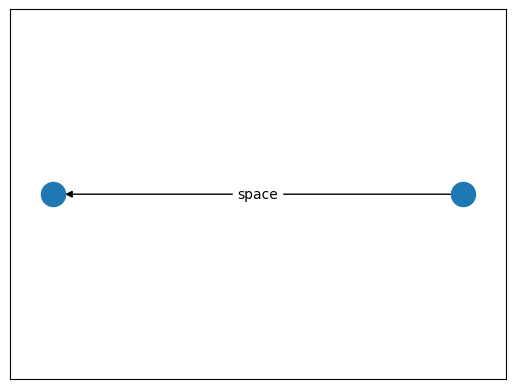

In [31]:
test_graph = nx.DiGraph()
test_graph.add_node('hello')
test_graph.add_node('hello')
test_graph.add_node('world')
test_graph.add_edge('hello', 'world', relation='space')
print(test_graph)
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

# nx.draw(test_graph, with_labels=True)
draw_graph(test_graph, 'relation')

In [32]:
nx.kamada_kawai_layout(test_graph)

{'hello': array([1.00000000e+00, 4.37113883e-08]),
 'world': array([-1.00000000e+00, -4.37113883e-08])}

[1, 2, 3, 4]
[(1, 2), (2, 3), (2, 4)]

[1, 2, 3, 4]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)]
{(1, 2): 'a', (2, 3): 'b', (2, 4): 'c'}


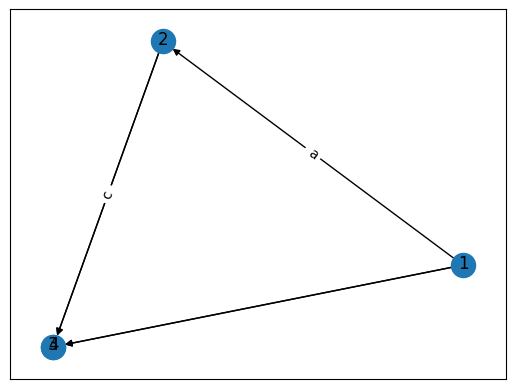

In [33]:
test_graph = nx.DiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'relation': 'a'}), (2,3, {'relation': 'b'}), (2, 4, {'relation': 'c'})])

print(test_graph.nodes)
print(test_graph.edges)

test_graph = nx.transitive_closure(test_graph, reflexive=False)
print()
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

draw_graph(test_graph, 'relation')


[1, 2, 3, 4, 10, 20]
[(1, 2, 0), (1, 2, 1), (1, 10, 0), (2, 3, 0), (2, 20, 0), (3, 4, 0)]
{(1, 2, 0): 'a', (1, 2, 1): 'b', (1, 10, 0): 'b', (2, 3, 0): 'a', (2, 20, 0): 'b', (3, 4, 0): 'a'}


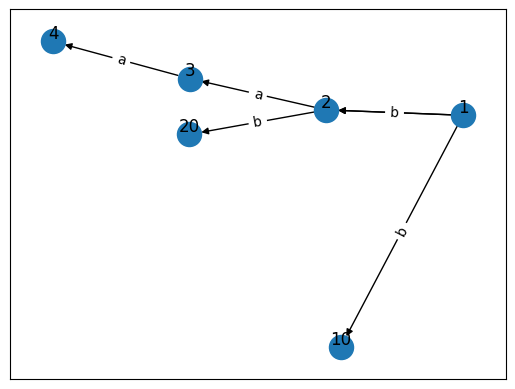

In [34]:
# NOTE: source need to be 
test_graph = nx.MultiDiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'rel': 'a'}), (2,3, {'rel': 'a'}), (3, 4, {'rel': 'a'})])

other_graph = nx.MultiDiGraph()
other_graph.add_nodes_from([1,2,3,10,20])
test_graph.add_edges_from([(1,2, {'rel': 'b'}), (1,10, {'rel': 'b'}), (2, 20, {'rel': 'b'})])

composed_graph = nx.compose(test_graph, other_graph)
print(composed_graph.nodes)
print(composed_graph.edges)
print(nx.get_edge_attributes(composed_graph, 'rel'))

draw_graph(composed_graph, 'rel')


-- mapto
timestamps, hlines, timestamps.now, days.selected, days, events, days.selected->events, rects, day-view, regions, nav-week, icons

timestamps ~> hlines
timestamps.now ~> timestamps
timestamps.now ~> hlines
days.selected ~> days
days.selected ~> events
days.selected->events ~> rects
day-view ~> regions
nav-week ~> icons

-- affects
time, timestamps, hlines

time ~> timestamps
time ~> hlines

-- covers
days, time, weeks, events

days ~> time
weeks ~> time
events ~> time



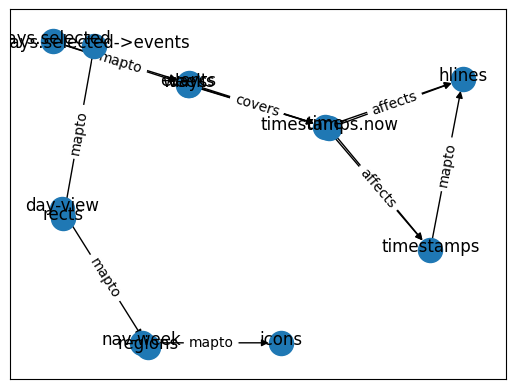

In [35]:
def make_spec_graphs(spec):
  graphs = {
    'mapto': nx.DiGraph(),
    'affects': nx.DiGraph(),
    'covers': nx.DiGraph()
  }

  obj_registry = ObjectRegistry(spec)
  
  for lhs, rhs_set in obj_registry.registry.items():
    # lhs = sanitize_name(lhs)
    for rhs in rhs_set:
      # rhs = sanitize_name(rhs)
      # Add mapto
      graphs['mapto'].add_nodes_from([lhs, rhs], ilk='object')
      graphs['mapto'].add_edge(lhs, rhs, rel='mapto')
  
  # Rule: Transitive closure on mapto
  graphs['mapto'] = nx.transitive_closure(graphs['mapto'])
  
  for obj in listable(spec.get('objects', [])):
    match = re.search("\(([\w-]+)\) (.*)", obj) # matches: (obj_type) obj_name
    if match is None:
      continue
    obj_type, obj_name = match.groups()
    obj_name = obj_name.split('->')[0].split('.')[0] 
    # prolog.append(f'type({obj_name}, {obj_type}).')

  for struct in spec.get('structures', []):
    # struct_name = sanitize_name(struct.get('name', None))
    struct_name = struct.get('name', None)
    graphs['affects'].add_node(struct_name, ilk='structure')

    if struct_type := struct.get('type'):
      # prolog.append(f'type({struct_name}, {struct_type}).')
      pass

    for affected in listable(struct.get('affects', [])):
      # prolog.append(f'affects({struct_name}, {affected}).')
      graphs['affects'].add_node(affected, ilk='object')
      graphs['affects'].add_edge(struct_name, affected, rel='affects')
      
      # Rule: S affects A & A mapto B => S affects B
      if affected in graphs['mapto'].nodes:
        for knock_on_affected in graphs['mapto'].neighbors(affected):
          graphs['affects'].add_node(knock_on_affected, ilk='object')
          graphs['affects'].add_edge(struct_name, knock_on_affected, rel='affects')
    
    for cover in listable(struct.get('covered-by', [])):
      # prolog.append(f'covered_by({struct_name}, {cover}).')
      graphs['covers'].add_node(cover, ilk='object')
      graphs['covers'].add_node(struct_name, ilk='structure')
      graphs['covers'].add_edge(cover, struct_name, rel='covers')
  
  return graphs

def draw_graphs(graphs):
  combined_graph = nx.compose_all(graphs.values())
  draw_graph(combined_graph, 'rel')

def print_graphs(graphs):
  for relation, graph in graphs.items():
    print('\n--', relation)
    print(', '.join(graph.nodes))
    print()
    for edge in graph.edges:
      print(f'{edge[0]} ~> {edge[1]}')
  print()
    
graphs = make_spec_graphs(parse_spec('calendar.yaml'))
print_graphs(graphs)
draw_graphs(graphs)

In [36]:
def heuristics(graphs):
  combined_graph = nx.compose_all(graphs.values())
  all_nodes = combined_graph.nodes
  node_neighbors = []

  # Outgoing Degree
  for node in all_nodes:
    total_degree = 0
    for rel, graph in graphs.items():
      if node in graph.nodes: 
        total_degree += len(list(nx.Graph(graph).neighbors(node)))
    node_neighbors.append((node, total_degree))
  
  print('-- Total of edges in & out of each nodes')
  for node, score in sorted(node_neighbors, key=lambda n: n[1], reverse=True):
    print(f'{node}: {score}')

graphs = make_spec_graphs(parse_spec('video-editor.yaml'))
heuristics(graphs)

-- Total of edges in & out of each nodes
videos: 6
editor-timeline: 6
videos.in-editor: 4
playhead: 4
tracks: 4
rects: 3
vlines: 3
videos.in-editor/images: 3
timestamps: 2
regions: 2
playhead->videos.in-editor/images: 1
videos/first-frame: 1
alphabetical: 1


In [ ]:
# print_graphs(graphs)
# graphs['affects'].nodes['time']

In [73]:
MAX_COST = 100
def node_match(n1, n2):
  print(n1, n2)
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return False
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return False
  
  return n1['ilk'] == n2['ilk']

def edge_match(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return False
  return e1['rel'] == e2['rel']

def node_subst_cost(n1, n2):
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return MAX_COST
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return MAX_COST
  
  if n1['ilk'] != n2['ilk']:
    return MAX_COST
  else:
    return 0

def edge_subst_cost(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return MAX_COST
  
  if e1['rel'] == e2['rel']:
    return 0
  else:
    return MAX_COST


In [39]:
print('---- as multiple graphs')
print_graphs(graphs)

print('\n---- as multi-graph')
composed_graph = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
print(composed_graph.nodes)

for (lhs, rhs, rel) in composed_graph.edges.data('rel', default='None'):
  print(f'{rel}: {lhs} --> {rhs}')
  # print(f'{lhs} --{rel}--> {rhs}')

---- as multiple graphs

-- mapto
videos.in-editor, videos, rects, timestamps, vlines, playhead, videos.in-editor/images, tracks, regions, playhead->videos.in-editor/images, videos/first-frame

videos.in-editor ~> videos
videos.in-editor ~> rects
timestamps ~> vlines
playhead ~> vlines
playhead ~> videos.in-editor/images
playhead ~> videos
videos.in-editor/images ~> videos
tracks ~> regions
playhead->videos.in-editor/images ~> rects
videos/first-frame ~> regions

-- affects
editor-timeline, timestamps, vlines, playhead, videos.in-editor/images, videos, tracks, videos.in-editor, rects, alphabetical

editor-timeline ~> timestamps
editor-timeline ~> vlines
editor-timeline ~> playhead
editor-timeline ~> videos.in-editor/images
editor-timeline ~> videos
tracks ~> videos.in-editor
tracks ~> videos
tracks ~> rects
alphabetical ~> videos

-- covers
videos.in-editor, editor-timeline

videos.in-editor ~> editor-timeline


---- as multi-graph
['videos.in-editor', 'videos', 'rects', 'timestamps', 

In [ ]:
def make_spec_multigraph(spec_name):
  spec = parse_spec(spec_name)
  graphs = make_spec_graphs(spec)

  composed = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
  # label representation nodes to facilitate matching
  # HACK: this should come core.yaml or should be in the name like `core/gui/icons`

  repr_objs = ['regions', 'rects', 'vlines', 'hlines', 'icons']
  for node_name in composed.nodes:
    composed.nodes[node_name]['repr_obj'] = node_name in repr_objs

  return composed


In [41]:
make_spec_multigraph('video-editor.yaml').nodes.data()

NodeDataView({'videos.in-editor': {'ilk': 'object', 'repr_obj': False}, 'videos': {'ilk': 'object', 'repr_obj': False}, 'rects': {'ilk': 'object', 'repr_obj': True}, 'timestamps': {'ilk': 'object', 'repr_obj': False}, 'vlines': {'ilk': 'object', 'repr_obj': True}, 'playhead': {'ilk': 'object', 'repr_obj': False}, 'videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'tracks': {'ilk': 'structure', 'repr_obj': False}, 'regions': {'ilk': 'object', 'repr_obj': True}, 'playhead->videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'videos/first-frame': {'ilk': 'object', 'repr_obj': False}, 'editor-timeline': {'ilk': 'structure', 'repr_obj': False}, 'alphabetical': {'ilk': 'structure', 'repr_obj': False}})

In [42]:
veditor_multigraph = make_spec_multigraph('video-editor.yaml')
calendar_multigraph = make_spec_multigraph('calendar.yaml')

In [59]:
pprint(list(veditor_multigraph.nodes.data()))
pprint(list(calendar_multigraph.nodes.data()))

[('videos.in-editor', {'ilk': 'object', 'repr_obj': False}),
 ('videos', {'ilk': 'object', 'repr_obj': False}),
 ('rects', {'ilk': 'object', 'repr_obj': True}),
 ('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('vlines', {'ilk': 'object', 'repr_obj': True}),
 ('playhead', {'ilk': 'object', 'repr_obj': False}),
 ('videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('tracks', {'ilk': 'structure', 'repr_obj': False}),
 ('regions', {'ilk': 'object', 'repr_obj': True}),
 ('playhead->videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('videos/first-frame', {'ilk': 'object', 'repr_obj': False}),
 ('editor-timeline', {'ilk': 'structure', 'repr_obj': False}),
 ('alphabetical', {'ilk': 'structure', 'repr_obj': False})]
[('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('hlines', {'ilk': 'object', 'repr_obj': True}),
 ('timestamps.now', {'ilk': 'object', 'repr_obj': False}),
 ('days.selected', {'ilk': 'object', 'repr_obj': False}),
 ('days', {'ilk': 'obj

In [57]:
def shuffled(things):
  temp = list(things)
  random.shuffle(temp)
  return temp

for pairing in zip(veditor_multigraph.nodes.data(), shuffled(list(calendar_multigraph.nodes.data()))):
  lhs, rhs = pairing
  print(f'{lhs[0]} == {rhs[0]}: {node_match(lhs[1], rhs[1])}')

videos.in-editor == rects: False
videos == icons: False
rects == regions: True
timestamps == hlines: False
vlines == nav-week: False
playhead == day-view: True
videos.in-editor/images == weeks: True
tracks == days: False
regions == timestamps: False
playhead->videos.in-editor/images == days.selected: True
videos/first-frame == days.selected->events: True
editor-timeline == events: False
alphabetical == timestamps.now: False


In [70]:
print(node_match(calendar_multigraph.nodes['rects'], veditor_multigraph.nodes['alphabetical']))

{'ilk': 'object', 'repr_obj': True} {'ilk': 'structure', 'repr_obj': False}
False


In [76]:
geds = nx.optimize_edit_paths(make_spec_multigraph('calendar.yaml'), make_spec_multigraph('video-editor.yaml'), 
                       timeout=10*60,
                       node_subst_cost=node_subst_cost,
                       edge_subst_cost=edge_subst_cost
                      #  node_match=node_match,
                      #  edge_match=edge_match,
                      #  strictly_decreasing=True,
                      #  roots=('time', 'editor-timeline')
                       )

In [77]:
for ged in geds:
  node_edit_path, edge_edit_path, cost = ged
  print('\n\n-- cost:', cost)
  
  print('- nodes')
  for node_edit in node_edit_path:
    lhs, rhs = node_edit
    print(f'{lhs} = {rhs}')

  print('\n- edges')
  for edge_edit in edge_edit_path:
    lhs, rhs = edge_edit

    if lhs is not None:
      edge_lhs, edge_rhs, _ = lhs
      lhs = f'{edge_lhs} ~ {edge_rhs}'

    if rhs is not None:
      edge_lhs, edge_rhs, _ = rhs
      rhs = f'{edge_lhs} ~ {edge_rhs}'
    
    print(f'{lhs} = {rhs}')


  # pprint(node_edit_path)
  # pprint(edge_edit_path)
  # print()

missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel


-- cost: 34.0
- nodes
timestamps = None
hlines = None
timestamps.now = videos
days.selected = timestamps
days = playhead
events = videos.in-editor/images
days.selected->events = playhead->videos.in-editor/images
rects = vlines
day-view = videos/first-frame
regions = regions
nav-week = videos.in-editor
icons = rects
time = tracks
weeks = None
None = editor-timeline
None = alphabetical

- edges
timestamps ~ hlines = None
timestamps.now ~ timestamps = None
timestamps.now ~ hlines = None
days.selected ~ days = None
None = playhead ~ videos
days.selected ~ events = None
None = playhead ~ videos.in-editor/images
None = videos.in-editor/images ~ videos
days.selected->events ~ rects = None
None = timestamps ~ vlines
None = playhead ~ vlines
day-view ~ regions = videos/first-frame ~ regions
None = videos.in-editor ~ videos
nav-week ~ icons